## Exam 20/03/2023


We work with the database ADNI, containing information for a clinical cohort of healhty volunteers and patients with Alzheimer's disease.

In [1]:
import numpy as np
import pandas as pd
import warnings
dataset = pd.read_csv('data.csv')
dataset[:10]
import matplotlib.pyplot as plt

Data fields:
- RID: subject's identifier
- Hippocampus_volume = normalized volume of the brain region hippocampus
- AGE: subject's age
- PTGENDER: subject's sex (1 Male, 2 Female)
- PTEDUCAT: years of education
- ADAS11: clinical score (Alzheimer's disease assessment scale)
- FDG: measure of average brain metabolism
- DX: clinical diagnosis. In order to severity we have NL (normal), MCI (mild cognitive impairment), and Dementia

__Exercise 1.__ Estimate mean and standard deviation for the classification accuracy of the algorithm Nearest Neighbour classifier for predicting clinical diagnosis based on the variables PTEDUCAT, ADAS11, and FDG. (use at least 1000 repetitions)

In [2]:
dataset.head(1)

,Unnamed: 0,RID,Hippocampus_volume,AGE,PTGENDER,PTEDUCAT,ADAS11,FDG,DX
0,1,2,0.0042,74.3,1,16,10.67,1.369264,NL


In [3]:
#Let's get rid of unwanted columns :
dataset=dataset.drop(columns=["Unnamed: 0",'RID'])
dataset.head(1)

,Hippocampus_volume,AGE,PTGENDER,PTEDUCAT,ADAS11,FDG,DX
0,0.0042,74.3,1,16,10.67,1.369264,NL


In [4]:
selected_var=['PTEDUCAT', 'ADAS11', 'FDG']
target='DX'
X=dataset[selected_var]
y=dataset['DX']

In [5]:
X.head(1)

,PTEDUCAT,ADAS11,FDG
0,16,10.67,1.369264


In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedKFold
n_iters=1000
knn = KNeighborsClassifier()
RKFold = RepeatedKFold(n_splits=2, n_repeats=n_iters)
knn_accuracies=[]

In [7]:
%%time
from sklearn.metrics import accuracy_score

warnings.filterwarnings('ignore')

for train, test in RKFold.split(X, y):
    X_train, y_train = X.iloc[train], y[train]
    X_test, y_test = X.iloc[test], y[test]

    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)
    knn_accuracies.append(accuracy_score(y_test, y_pred_knn))


CPU times: total: 36.8 s
Wall time: 46.5 s


In [8]:
knn_accuracy_mean=np.mean(knn_accuracies)
knn_accuracy_std=np.std(knn_accuracies)

print("Knn mean accuracy =",knn_accuracy_mean)
print("Knn mean standard deviation =",knn_accuracy_std)

Knn mean accuracy = 0.615732850808555
Knn mean standard deviation = 0.016657121071567076


__Exercise 2__. Compute a 95% confidence interval for the median FDG in the group Dementia, and in the group healthy (NL). Are the median significantly different?  



Let's create 2 new dataset : One for healthy subject (NL) and one for subjects with dementia.

In [9]:
nl = dataset[dataset['DX'] == "NL"]
dementia = dataset[dataset['DX'] == "Dementia"]

Let's do a boostrap estimate of both medians.

In [10]:
alpha = 0.05
n_boot_rep = 3000
conf_level = alpha / 2 * n_boot_rep

Compute the confidence interval for healthy patients :

    For the bootsrap, we take randomly elements inside of the healthy patient dataset.

In [11]:

boot = np.random.choice(nl["FDG"],
                        size=(len(nl),
                        n_boot_rep),
                        replace=True)

boot_median = np.median(boot, axis=0)

low = np.sort(boot_median)[int(conf_level)]
up = np.sort(boot_median)[int(n_boot_rep - conf_level)]

print(
    f"The {100-alpha*100}% confidence interval for the median is : [{low},{up}]")

The 95.0% confidence interval for the median is : [1.2971560000000002,1.324486]


Compute the confidence interval for patients with Dementia :

    For the bootsrap, we take randomly elements inside of the patient with dementia.

In [12]:
boot = np.random.choice(dementia["FDG"],
                        size=(len(dementia),
                        n_boot_rep),
                        replace=True)
boot_median = np.median(boot, axis=0)
low = np.sort(boot_median)[int(conf_level)]
up = np.sort(boot_median)[int(n_boot_rep - conf_level)]

print(
    f"The {100-alpha*100}% confidence interval for the median is : [{low},{up}]")

The 95.0% confidence interval for the median is : [1.04165,1.0974439999999999]


Let's test the significance of the difference of the two confidence intervals :

Median healthy :  1.30989
Median dementia :  1.064245
The observed difference of median is : 0.246
statistical test for the difference (p-value):  0.0


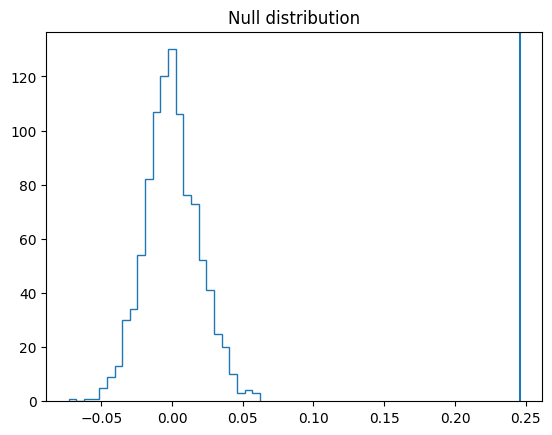

In [13]:
x=nl['FDG']
y=dementia['FDG']

def boostrap_groups(x,y, B = 1):
    z = np.concatenate([x, y])
    diff_boostrap =np.empty(B)
    #perform bootsrap
    for i in range(B):
        permuted_data = np.random.choice(z, len(z), replace = True)
        perm_sample_1 = permuted_data[:len(x)]
        perm_sample_2 = permuted_data[len(x):]
        #compute bootsrap difference of the medians
        diff_boostrap[i] = np.median(perm_sample_1) - np.median(perm_sample_2)
    
    #compute final difference of the median
    real_diff = np.median(x) - np.median(y)
    print('Median healthy : ', np.median(x))
    print('Median dementia : ', np.median(y))
    print("The observed difference of median is :",round(real_diff,3))
    print('statistical test for the difference (p-value): ', 1-np.sum(real_diff>diff_boostrap)/B)
    plt.hist(diff_boostrap, 25, histtype='step')
    plt.title('Null distribution')
    plt.axvline(x = real_diff)
    plt.show()

boostrap_groups(x,y,B=1000)

**Conclusion** : According to the null distribution, we can see that the difference between the two median is significant, the median for FDG Healthy and FDG Dementia is not the same. (We reject the null hypothesis)

__Exercise 3.__ Use the information criteria to decide what is the best polynomial model that explains the relatioship between age (predictor) and ADAS11 (target) in the group MCI? And in the group NL? 

I will use BIC, AIC and AICc as information criteria.

1st, let's reduce the dataset by taking only AGE, ADAS11 and DX:

In [14]:
reduced_df = dataset[["AGE", "ADAS11", "DX"]]

Take only the rows where DX == Given group and then drop the column DX to only have the features whose relationship is to be explained

In [15]:
NL_df = reduced_df[reduced_df['DX'] == "NL"].drop(columns=["DX"])
MCI_df = reduced_df[reduced_df['DX'] == "MCI"].drop(columns=["DX"])

Compute the Gaussian log-likelihood :


In [16]:
def Gaussian_loglik(x,y,w,sigma2):

    N = len(y)
    ll = -N/2 * np.log(2*np.pi*sigma2) - 1/(2*sigma2) * np.sum((y-x.dot(w.T))**2)
    return ll


Fit a polymonial model :

In [17]:
def fit_poly(x,y,d):
    w_ml = np.linalg.solve(x.T.dot(x),x.T.dot(y))
    w_ml.reshape(1,(len(w_ml)))
    sigma2_ml = np.mean((y-x.dot(w_ml.T))**2)
    return w_ml, sigma2_ml

Grid search on a polynomial model

In [18]:
def poly_search(x, y, d):
    loglik = []
    AIC = []
    AICc = []
    BIC = []
    for d in range(1,d):
        x_poly = np.array([x**i for i in range(d)]).T
        w_ml, sigma2_ml = fit_poly(x_poly,y,d)
        loglik.append(Gaussian_loglik(x_poly,y,w_ml,sigma2_ml))
        dev = -2*np.array(Gaussian_loglik(x_poly, y, w_ml, sigma2_ml))
        AIC.append(dev+2*len(w_ml))
        BIC.append(dev+2*len(w_ml)*np.log(len(x)))
        AICc.append(dev+2*len(w_ml) + 2*d + 2.*d*(d+1)/(x.shape[0]-d-1))
    return AIC, AICc, BIC

Let's apply and plot the functions for both group :

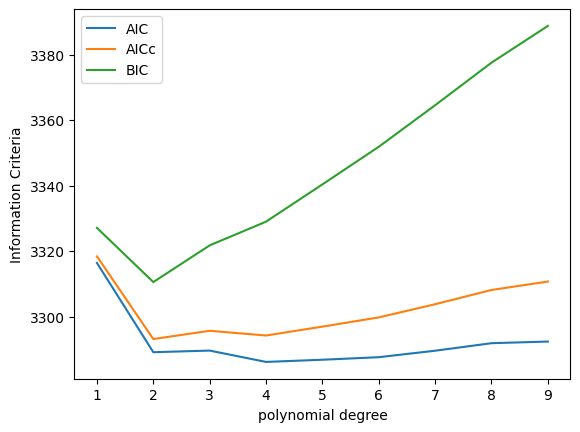

In [19]:
degrees = 10
AIC, AICc, BIC = poly_search(MCI_df["AGE"], MCI_df["ADAS11"], degrees)

plt.plot(range(1,degrees), AIC, label = "AIC")
plt.ylabel('Information Criteria')
plt.plot(range(1,degrees), AICc, label = "AICc")
plt.plot(range(1,degrees), BIC, label = "BIC")
plt.xlabel('polynomial degree')
plt.legend()
plt.show()

Here, we have multiple choice, we obsere that :

    - The best polynomial degree for BIC is 2
    
    - The best polynomial degree for AICc is 2
    
    - The best polynomial degree for AIC is 4
    
In `lesson 8`, we have seen that :

We note that when $N$ is very large, the AICc converges to AIC, while the correction factor will be more relevant for small sample sizes. The rule of thumb for using AICc is when the ratio $\frac{N}{N_{parameters}}$ is less than 40, and in general, AICc is always preferred to AIC.

**Thus, here, we can focus on AICc and BIC and in this case,the best model to chose is a model with polynomial degree = 2**
    
    

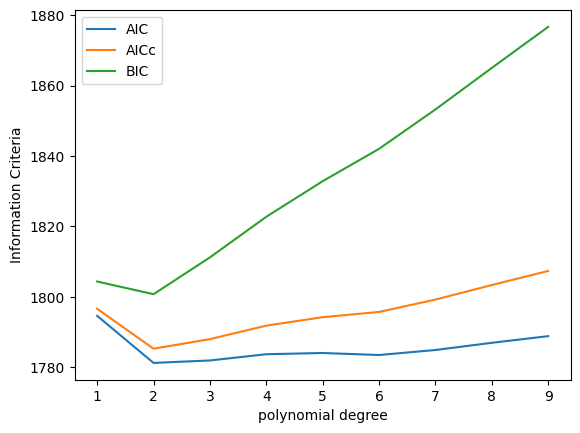

In [20]:
degrees = 10
AIC, AICc, BIC = poly_search(NL_df["AGE"], NL_df["ADAS11"], degrees)

plt.plot(range(1,degrees), AIC, label = "AIC")
plt.ylabel('Information Criteria')
plt.plot(range(1,degrees), AICc, label = "AICc")
plt.plot(range(1,degrees), BIC, label = "BIC")
plt.xlabel('polynomial degree')
plt.legend()
plt.show()

Here, we also have multiple choice, we obsere that :

    - The best polynomial degree for BIC is 2
    
    - The best polynomial degree for AICc is 2
    
    - The best polynomial degree for AIC is 2
    
**As every information criteria are the same we can clearly say that the best model to chose is also a model with polynomial degree = 2**
    





**Conclusion :** Here, we have seen that in both case, the best model to chose is a model with polynomial degree=2, we have also seen that the information criterion can differ and we need to chose the right one according to the situation. Here, we have chosen to focus on AICc/BIC for the first case because there was few parameters and the two were giving the same answer, which is reassuring.

__Exercise 4.__ Repeat Exercise 3 by using leave one out, and compare the results.

In [21]:
x2=[1,2,3]
np.delete(x2,2)

array([1, 2])

In [22]:
from sklearn.model_selection import train_test_split
y=NL_df["ADAS11"]
X=NL_df["AGE"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [23]:
# def loo_poly_search(x, y, d):
#     n = len(x)
#     mse = []
#     for i in range(n):
#         x_train = np.delete(x,i)
#         y_train = np.delete(y.ravel(), i)
#         x_test = x[i]
#         y_test = y[i]
#         x_train_poly = np.array([x_train**j for j in range(1, d+1)]).T
#         w_ml, sigma2_ml = fit_poly(x_train_poly, y_train, d)
#         y_pred = x_test.dot(w_ml.T)
#         mse.append((y_test - y_pred)**2)
#     return np.mean(mse)

# degrees = 10
# mse = []
# for d in range(1, degrees):
#     mse.append(loo_poly_search(MCI_df["AGE"], MCI_df["ADAS11"], d))

# plt.plot(range(1, degrees), mse)
# plt.xlabel('polynomial degree')
# plt.ylabel('LOO prediction error')
# plt.show()


__Exercise 5.__ What is the best combination of variables (excluded RID and DX) for predicting PTEDUCAT with a linear model?

In [24]:
selected_5=['Hippocampus_volume','PTGENDER','ADAS11','FDG']

X_5=dataset[selected_5]
y_5=dataset['PTEDUCAT']

In [25]:
X_5.head(2)

,Hippocampus_volume,PTGENDER,ADAS11,FDG
0,0.004200,1,10.67,1.369264
1,0.002769,1,22.00,1.090790


Redefine fit poly without de degree parameter

In [26]:
def fit_poly2(x,y):
    w_ml = np.linalg.solve(x.T.dot(x),x.T.dot(y))
    w_ml.reshape(1,(len(w_ml)))
    sigma2_ml = np.mean((y-x.dot(w_ml))**2)
    return w_ml, sigma2_ml

In [27]:
def Gaussian_loglik(x,y,w,sigma2):
    N = len(y)
    ll = -N/2 * np.log(2*np.pi*sigma2) - 1/(2*sigma2) * np.sum((y-x.dot(w))**2)
    return ll

Now, we are going to compare each different combinations of feature. For the comparison we are going to use AIC, AICc and BIC.

In [28]:
def compare_tables(features, target, max_number_of_columns):
    AIC = []
    AICc = []
    BIC = []
    model = []
    ll = []
    coef = []
    sigma2 = []

    # For each number of parameters in the model
    for n_elements in range(1,10):
        # For each combination of variables
        for indices in itertools.combinations(range(max_number_of_columns), n_elements):

            # Store the indices corresponding to the parameters
            model.append(indices)
            # Fit the model
            x_train = features.values[:,indices].reshape(features.values.shape[0],n_elements)
            w_ml, sigma2_ml = fit_poly2(x_train, target.values)

            # compute the log-likelihhod
            training_ll = Gaussian_loglik(x_train,target,w_ml,sigma2_ml)

            # store the coefficients
            coefficients = np.zeros(max_number_of_columns)
            coefficients[[indices]] = w_ml.T        
            coef.append(coefficients)
            sigma2.append(sigma2_ml)

            # store all the metrics
            ll.append(float(-training_ll))
            AIC.append(float(-2*training_ll + 2*n_elements))
            AICc.append(float(-2*training_ll + 2*n_elements + 2.*n_elements*(n_elements+1)/(features.values.shape[0]-n_elements-1)))
            BIC.append(float(-2*training_ll + 2*n_elements*np.log(features.values.shape[0])))

    results = pd.DataFrame({'model': model, 'AIC': AIC, 'AICc': AICc, 'BIC' :BIC, 
                            'neg_loglik' : ll, 'coef' : coef, 'sigma2' : sigma2})  
    return results

In [29]:
nb_cols=4
import itertools
results = compare_tables(X_5, y_5, nb_cols)

In [30]:
results.sort_values('AIC', ascending = True, inplace = True)
results.reset_index(inplace = True)
model_comparison = results[['model', 'AIC', 'AICc', 'BIC']]

fitted_models = results[['model', 'coef', 'sigma2']]

Let's plot the table. This table is sorted on the smallest AIC value, we can see for each combination of feature, their different AIC, AICc and BIC. The difference columns is the difference between lowest AIC and current AIC.

In [31]:
differences_wrt_minimum = model_comparison.AIC - model_comparison.AIC[0]
model_comparison.insert(len(model_comparison.columns), 'difference', differences_wrt_minimum)
model_comparison[:10]


,model,AIC,AICc,BIC,difference
0,"(0, 1, 2, 3)",5785.934084,5785.969482,5834.209188,0.000000
1,"(0, 2, 3)",5797.955565,5797.976785,5834.161893,12.021481
2,"(1, 2, 3)",5820.225822,5820.247043,5856.432150,34.291738
3,"(2, 3)",5823.776068,5823.786668,5847.913619,37.841984
4,"(0, 1, 3)",5921.433710,5921.454930,5957.640037,135.499626
5,"(0, 3)",5922.240822,5922.251423,5946.378374,136.306738
6,"(3,)",5940.807450,5940.810980,5952.876226,154.873366
7,"(1, 3)",5942.449053,5942.459654,5966.586605,156.514969
8,"(0, 2)",6137.958968,6137.969569,6162.096520,352.024884
9,"(0, 1, 2)",6139.897415,6139.918635,6176.103742,353.963330


In [32]:
print(X_5.columns)

Index(['Hippocampus_volume', 'PTGENDER', 'ADAS11', 'FDG'], dtype='object')


In the case where we want to rely on the AIC and/or AICc, we chose the first line because it the the line with AIC and AIcc minimum, and in this case, all the features are selected. Here, the best combination is all the features.

In [33]:
model_comparison[model_comparison['AIC']==min(model_comparison['AIC'])]

,model,AIC,AICc,BIC,difference
0,"(0, 1, 2, 3)",5785.934084,5785.969482,5834.209188,0.0


AICc minimum :

In [34]:
model_comparison[model_comparison['AICc']==min(model_comparison['AICc'])]

,model,AIC,AICc,BIC,difference
0,"(0, 1, 2, 3)",5785.934084,5785.969482,5834.209188,0.0


In the case where we want to rely on BIC, we chose the line where BIC is min :

In [35]:
model_comparison[model_comparison['BIC']==min(model_comparison['BIC'])]

,model,AIC,AICc,BIC,difference
1,"(0, 2, 3)",5797.955565,5797.976785,5834.161893,12.021481


Thus, in this case, the best set of features is : Hippocampus_volume, ADAS11 and FDG

**I personnaly think that in this case, it is better to rely on AIC/AICc because they both indicates the same combination of features and in any case, the minimum BIC is not too far from the one where AIC is minimum.**

**Conclusion :** the best set of feature to chose is 0,1,2,3 ==> Which are all the features.

__Open question__. Is it true that a model with the lowest AIC is the best one? 

As seen previously, taking the lowest AIC is not always the best one. We have seen in Exercise 3 that when $N$ is very large, the AICc converges to AIC, while the correction factor will be more relevant for small sample sizes. The rule of thumb for using AICc is when the ratio $\frac{N}{N_{parameters}}$ is less than 40, and in general, AICc is often preferred to AIC.

Also, sometimes the BIC is preferable as we have seen in **`lesson 8`**, the penalty term of the BIC is larger than the one from AIC. BIC is then preferable when the model is very simple and describe the data as simple as possible.

In [36]:
print("all cells were executed correctly")

all cells were executed correctly
